# Neo4j Runway: End-to-End Graph Creation Example

*Updated: August 20, 2024 for Neo4j Runway v 0.9*



## Introduction
This notebook demonstrates how to use Neo4j Runway to:
* use an LLM to generate a graph data model from a CSV,
* generate Cypher code to load the .csv data into a Neo4j Graph Database. 

Neo4j Runway is an open source library created by my colleague [Alex Gilmore](https://medium.com/@a-gilmore). You can find the [repo here](https://github.com/a-s-g93/neo4j-runway) and a blog describing the library [here](https://medium.com/neo4j/easy-data-ingestion-with-neo4j-runway-and-arrows-app-1e5f121333a7).

As you will see in the notebook, all of this is performed **without writing a single line of Cypher.** This demonstrates the promise of using LLMs to faciliate graph generation and graph loading. 

Additionally, it is important to remember that Neo4j makes it easy to iterate on your graph data model. The goal of Neo4j Runway is to help you get started with something that is close to your final data model so that you can start working with the data as a graph as quickly as possible. 

When working wtih customers we find that many of the finishing touches on a graph data model can only come once you interact with the data in a graph database. Tools like Neo4j runway get you from tabular data to working graph database quickly. 

*Note: Neo4j Runway is in early stages of development. It is an open source project and not officially supported by Neo4j.*

## Install and Import Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# !pip install graphviz --quiet --upgrade
# !pip install neo4j_runway --upgrade --quiet
from neo4j_runway import Discovery, GraphDataModeler, PyIngest, UserInput
from neo4j_runway.code_generation import PyIngestConfigGenerator
from neo4j_runway.llm.openai import OpenAIDiscoveryLLM, OpenAIDataModelingLLM



In [3]:
# !pip install python-dotenv --upgrade --quiet
from dotenv import load_dotenv
import os

In [4]:
# function to print markdown
from IPython.display import display, Markdown, Image
def print_markdown(text):
    display(Markdown(text))

## Load Environment Variables
We will need an OpenAI API key along with the URL and Password for the Neo4j database. These are stored in a local `.env` file.

In [5]:
# read in from .env file
load_dotenv(dotenv_path='.env')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE')

## Load and Explore Data
For this example we will use the record of bank failures in the United States. This data is published by the Federal Deposit Insurance Corporation (FDIC) and is available at https://www.fdic.gov/bank/individual/failed/banklist.csv. 

This data was new to me as I worked on this notebook, so I did not know what it contained or what a potential graph data model might look like. This is a good test for the LLM to see if it can generate a useful graph data model.

In [6]:
# read data directly into a dataframe 
failedBank_df = pd.read_csv('https://www.fdic.gov/system/files/2024-07/banklist.csv', 
                            encoding='ISO-8859-1',
                            sep=',',
                            on_bad_lines='skip')
failedBank_df.shape

(569, 7)

In [7]:
failedBank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Bank Name               569 non-null    object
 1   City                    569 non-null    object
 2   State                   569 non-null    object
 3   Cert                    569 non-null    int64 
 4   Acquiring Institution   569 non-null    object
 5   Closing Date            569 non-null    object
 6   Fund                    569 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 31.2+ KB


In [8]:
failedBank_df.head()

,Bank Name,City,State,Cert,Acquiring Institution,Closing Date,Fund
0,Republic First Bank dba Republic Bank,Philadelphia,PA,27332,"Fulton Bank, National Association",26-Apr-24,10546
1,Citizens Bank,Sac City,IA,8758,Iowa Trust & Savings Bank,3-Nov-23,10545
2,Heartland Tri-State Bank,Elkhart,KS,25851,"Dream First Bank, N.A.",28-Jul-23,10544
3,First Republic Bank,San Francisco,CA,59017,"JPMorgan Chase Bank, N.A.",1-May-23,10543
4,Signature Bank,New York,NY,57053,"Flagstar Bank, N.A.",12-Mar-23,10540


## Preprocess Data
The data contained spaces in the column names. Additionally, all data currently needs to be strings to be loaded into the data model, so we will take care of that first. 

In [9]:
# trim whitepace from column names
failedBank_df.columns = failedBank_df.columns.str.strip()
failedBank_df.columns

Index(['Bank Name', 'City', 'State', 'Cert', 'Acquiring Institution',
       'Closing Date', 'Fund'],
      dtype='object')

In [10]:
# convert all columns to strings
failedBank_df['Cert'] = failedBank_df['Cert'].astype(str)
failedBank_df['Closing Date'] = failedBank_df['Closing Date'].astype(str)
failedBank_df['Fund'] = failedBank_df['Fund'].astype(str)

In [11]:
# write to .csv 
failedBank_df.to_csv('data/failedBank.csv', index=False)

## Describe Data
In this section we need to create a key-value pairs describing the features of our data:
* The `general_description` should contain a high-level overview of the data. 
* The `column descriptions` should contain a dictionary with the column name as the key and a description of the column as the value.

In [12]:
USER_GENERATED_INPUT = UserInput(general_description='This dataset contains a list of failed banks in the United States.',
                                 column_descriptions={
                                            'Bank Name': 'Name of the failed bank.',
                                            'City': 'City where the failed bank was headquartered.',
                                            'State': 'State where the failed bank was headquartered.',
                                            'Cert': 'FDIC certificate number of the failed bank.',
                                            'Acquiring Institution': 'Name of the institution that acquired the failed bank.',
                                            'Closing Date': 'Date that the failed bank closed.',
                                            'Fund': 'FDIC fund number of the failed bank, which acts as a unique identifier in this data set.'
                                            },
                                use_cases=[
                                    "What are patterns among the locations of failed banks?",
                                    "What are connections among the acquiring institutions of failed banks?"
                                    ]
                                )

## Use the LLM to Perform Exploratory Data Analysis
Before asking the LLM to generate a data model, we will first ask it to analyze the tabular data. This will identify statistical and categorical elements of the data that are important for generating a graph data model.

In [13]:
# instantiate llm
disc_llm = OpenAIDiscoveryLLM()

In [14]:
# pass data and descriptions to LLM
disc = Discovery(llm=disc_llm, user_input=USER_GENERATED_INPUT, data=failedBank_df)
disc.run()

Based on the provided summary of the dataset, here is a preliminary analysis focusing on the use cases of identifying patterns among the locations of failed banks and connections among the acquiring institutions:

### Overall Details about the Data

1. **Data Size and Completeness**:
   - The dataset contains 569 entries with 7 features.
   - There are no missing values in the dataset, which is beneficial for analysis.

2. **Data Types**:
   - All features are of type `object`, indicating they are categorical or string data.

3. **Unique Values**:
   - Most features have a high number of unique values, which suggests a diverse dataset.

### Important Features

1. **Bank Name**:
   - There are 551 unique bank names out of 569 entries.
   - The most frequent bank name is "The First State Bank," appearing 3 times.
   - This feature can help identify specific banks that have failed multiple times.

2. **City**:
   - There are 436 unique cities.
   - The most frequent city is Chicago, with 20 occurrences.
   - This feature is crucial for identifying geographic patterns of bank failures.

3. **State**:
   - There are 44 unique states.
   - The most frequent state is Georgia (GA), with 93 occurrences.
   - This feature is essential for understanding state-level patterns in bank failures.

4. **Cert**:
   - Each entry has a unique FDIC certificate number.
   - This feature can be used as a unique identifier for each bank.

5. **Acquiring Institution**:
   - There are 303 unique acquiring institutions.
   - The most frequent acquiring institution is "No Acquirer," appearing 31 times.
   - This feature is key for analyzing connections among acquiring institutions.

6. **Closing Date**:
   - There are 264 unique closing dates.
   - The most frequent closing date is "30-Oct-09," with 9 occurrences.
   - This feature can help identify temporal patterns in bank failures.

7. **Fund**:
   - Each entry has a unique FDIC fund number.
   - This feature acts as a unique identifier within the dataset.

### Analysis for Use Cases

1. **Patterns among the Locations of Failed Banks**:
   - **State and City**: These features are critical for identifying geographic patterns. The high frequency of bank failures in specific states (e.g., Georgia) and cities (e.g., Chicago) suggests regional trends.
   - **Bank Name**: Identifying banks that have failed multiple times in the same or different locations can provide insights into regional banking stability.

2. **Connections among the Acquiring Institutions of Failed Banks**:
   - **Acquiring Institution**: This feature is central to understanding the network of acquiring institutions. The presence of "No Acquirer" as the most frequent value indicates that a significant number of banks were not acquired.
   - **Cert and Fund**: These unique identifiers can help track specific banks and their acquiring institutions, facilitating the analysis of connections and patterns.

### Summary

- **State** and **City** are the most important features for analyzing geographic patterns of failed banks.
- **Acquiring Institution** is the most important feature for understanding connections among acquiring institutions.
- **Bank Name**, **Cert**, and **Fund** provide unique identifiers that can help in detailed tracking and analysis.
- **Closing Date** can help identify temporal trends in bank failures.

This preliminary analysis sets the stage for a more detailed exploration of the data, which can inform the design of a graph data model in Neo4j to address the specified use cases.

## Use LLM to Create Initial Data Model
Now that we have analyzed the statistical and categorical features of the data, we can have the LLM generate an initial data model. This initial data model will point is in the right direction, but is unlikely to be perfect. That is perfectly fine because we can continue iterating it using the LLM and then once we have the data in Neo4j. The objective is to get from the tabular data to the start of a graph data model as quickly as possible.

In [15]:
modeling_llm = OpenAIDataModelingLLM()

In [16]:
gdm = GraphDataModeler(llm=modeling_llm, discovery=disc)
gdm.create_initial_model()

validation failed
performing chain of thought process for error fix recommendations...
validation failed
performing chain of thought process for error fix recommendations...
validation failed
performing chain of thought process for error fix recommendations...


DataModel(nodes=[Node(label='Bank', properties=[Property(name='bankName', type='str', csv_mapping='Bank Name', csv_mapping_other=None, is_unique=True, part_of_key=False), Property(name='cert', type='str', csv_mapping='Cert', csv_mapping_other=None, is_unique=False, part_of_key=True), Property(name='fund', type='str', csv_mapping='Fund', csv_mapping_other=None, is_unique=False, part_of_key=True)], csv_name='banks.csv'), Node(label='Location', properties=[Property(name='city', type='str', csv_mapping='City', csv_mapping_other=None, is_unique=False, part_of_key=True), Property(name='state', type='str', csv_mapping='State', csv_mapping_other=None, is_unique=False, part_of_key=True)], csv_name='locations.csv'), Node(label='Institution', properties=[Property(name='acquiringInstitution', type='str', csv_mapping='Acquiring Institution', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name='institutions.csv'), Node(label='Closure', properties=[Property(name='closingDate', type=

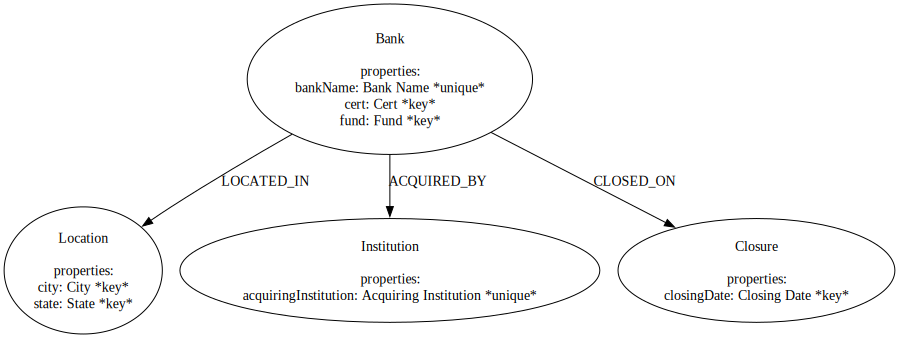

In [17]:
gdm.current_model.visualize()

## Iterate the Data Model 
Once we see the initial model we can suggest corrections. It is a best practice to make these suggestions as clear and direct as possible.

In [18]:
gdm.iterate_model(corrections='''
This is a good start. Please make the following updates to the graph data model:

1. Remove and discard the fund property from the Bank node. We will not use this data. 
2. Remove the uniqueness constraint from bankName on the Bank node. 
3. Move the closingDate property from the Closure node to the ACQUIRED_BY relationship, without a uniqueness constraint.
4. Remove the Closure node from the data model. 

Make only the above changes. Do not make any other changes to the graph data model. 
''')

validation failed
performing chain of thought process for error fix recommendations...
recieved a valid response


DataModel(nodes=[Node(label='Bank', properties=[Property(name='bankName', type='str', csv_mapping='Bank Name', csv_mapping_other=None, is_unique=False, part_of_key=True), Property(name='cert', type='str', csv_mapping='Cert', csv_mapping_other=None, is_unique=False, part_of_key=True)], csv_name='banks.csv'), Node(label='Location', properties=[Property(name='city', type='str', csv_mapping='City', csv_mapping_other=None, is_unique=False, part_of_key=True), Property(name='state', type='str', csv_mapping='State', csv_mapping_other=None, is_unique=False, part_of_key=True)], csv_name='locations.csv'), Node(label='Institution', properties=[Property(name='acquiringInstitution', type='str', csv_mapping='Acquiring Institution', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name='institutions.csv')], relationships=[Relationship(type='LOCATED_IN', properties=[], source='Bank', target='Location', csv_name=''), Relationship(type='ACQUIRED_BY', properties=[Property(name='closingDate

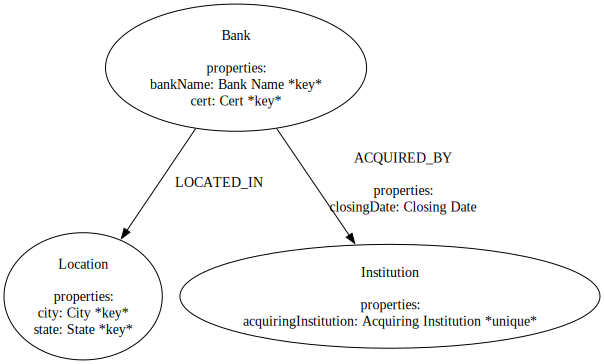

In [19]:
# visualize the updated data model
gdm.current_model.visualize()

## Generate Ingestion Code
Once we have a graph data model that we are happy with, we can generate the Cypher code and YAML file to load the data into Neo4j.

In [28]:
gen = PyIngestConfigGenerator(data_model=gdm.current_model, 
                              username='neo4j', 
                              password=NEO4J_PASSWORD, 
                              uri=NEO4J_URI,
                              database=NEO4J_DATABASE, 
                              file_directory="data/", 
                              csv_name="failedBank.csv")

In [29]:
# create ingestion YAML 
config = gen.generate_config_string()

In [30]:
# save local copy of YAML
gen.generate_config_yaml(file_name="failedBanks.yaml")

## Load Data into Neo4j 
The last step is to load the data into Neo4j. From there we can explore the data in Neo4j itself or by using one of the Neo4j Python connectors. 

In [31]:
# # verify connection to database
# from neo4j_runway.utils import test_database_connection
# credentials = {
#     "uri": NEO4J_URL,
#     "password": NEO4J_PASSWORD,
#     "database": NEO4J_DATABASE
# }
# test_database_connection(credentials=credentials)

In [32]:
# ingest the data 
PyIngest(config=config, dataframe=failedBank_df)


File {} .//data/failedBank.csv
loading... 0 2024-08-20 15:45:51.962618
loading... 1 2024-08-20 15:45:52.241461
loading... 2 2024-08-20 15:45:52.292108
loading... 3 2024-08-20 15:45:52.327557
loading... 4 2024-08-20 15:45:52.357893
{} : Completed file 2024-08-20 15:45:52.389947
File {} .//data/failedBank.csv
loading... 0 2024-08-20 15:45:52.390505
loading... 1 2024-08-20 15:45:52.451934
loading... 2 2024-08-20 15:45:52.474933
loading... 3 2024-08-20 15:45:52.496741
loading... 4 2024-08-20 15:45:52.517550
{} : Completed file 2024-08-20 15:45:52.538459
File {} .//data/failedBank.csv
loading... 0 2024-08-20 15:45:52.539038
loading... 1 2024-08-20 15:45:52.616399
loading... 2 2024-08-20 15:45:52.637354
loading... 3 2024-08-20 15:45:52.656616
loading... 4 2024-08-20 15:45:52.673100
{} : Completed file 2024-08-20 15:45:52.690276
File {} .//data/failedBank.csv
loading... 0 2024-08-20 15:45:52.691336
loading... 1 2024-08-20 15:45:52.889928
loading... 2 2024-08-20 15:45:52.930704
loading... 3 20

## View Graph
Now that we have the data loaded into Neo4j, we can view it using the Neo4j Browser or Neo4j Bloom.

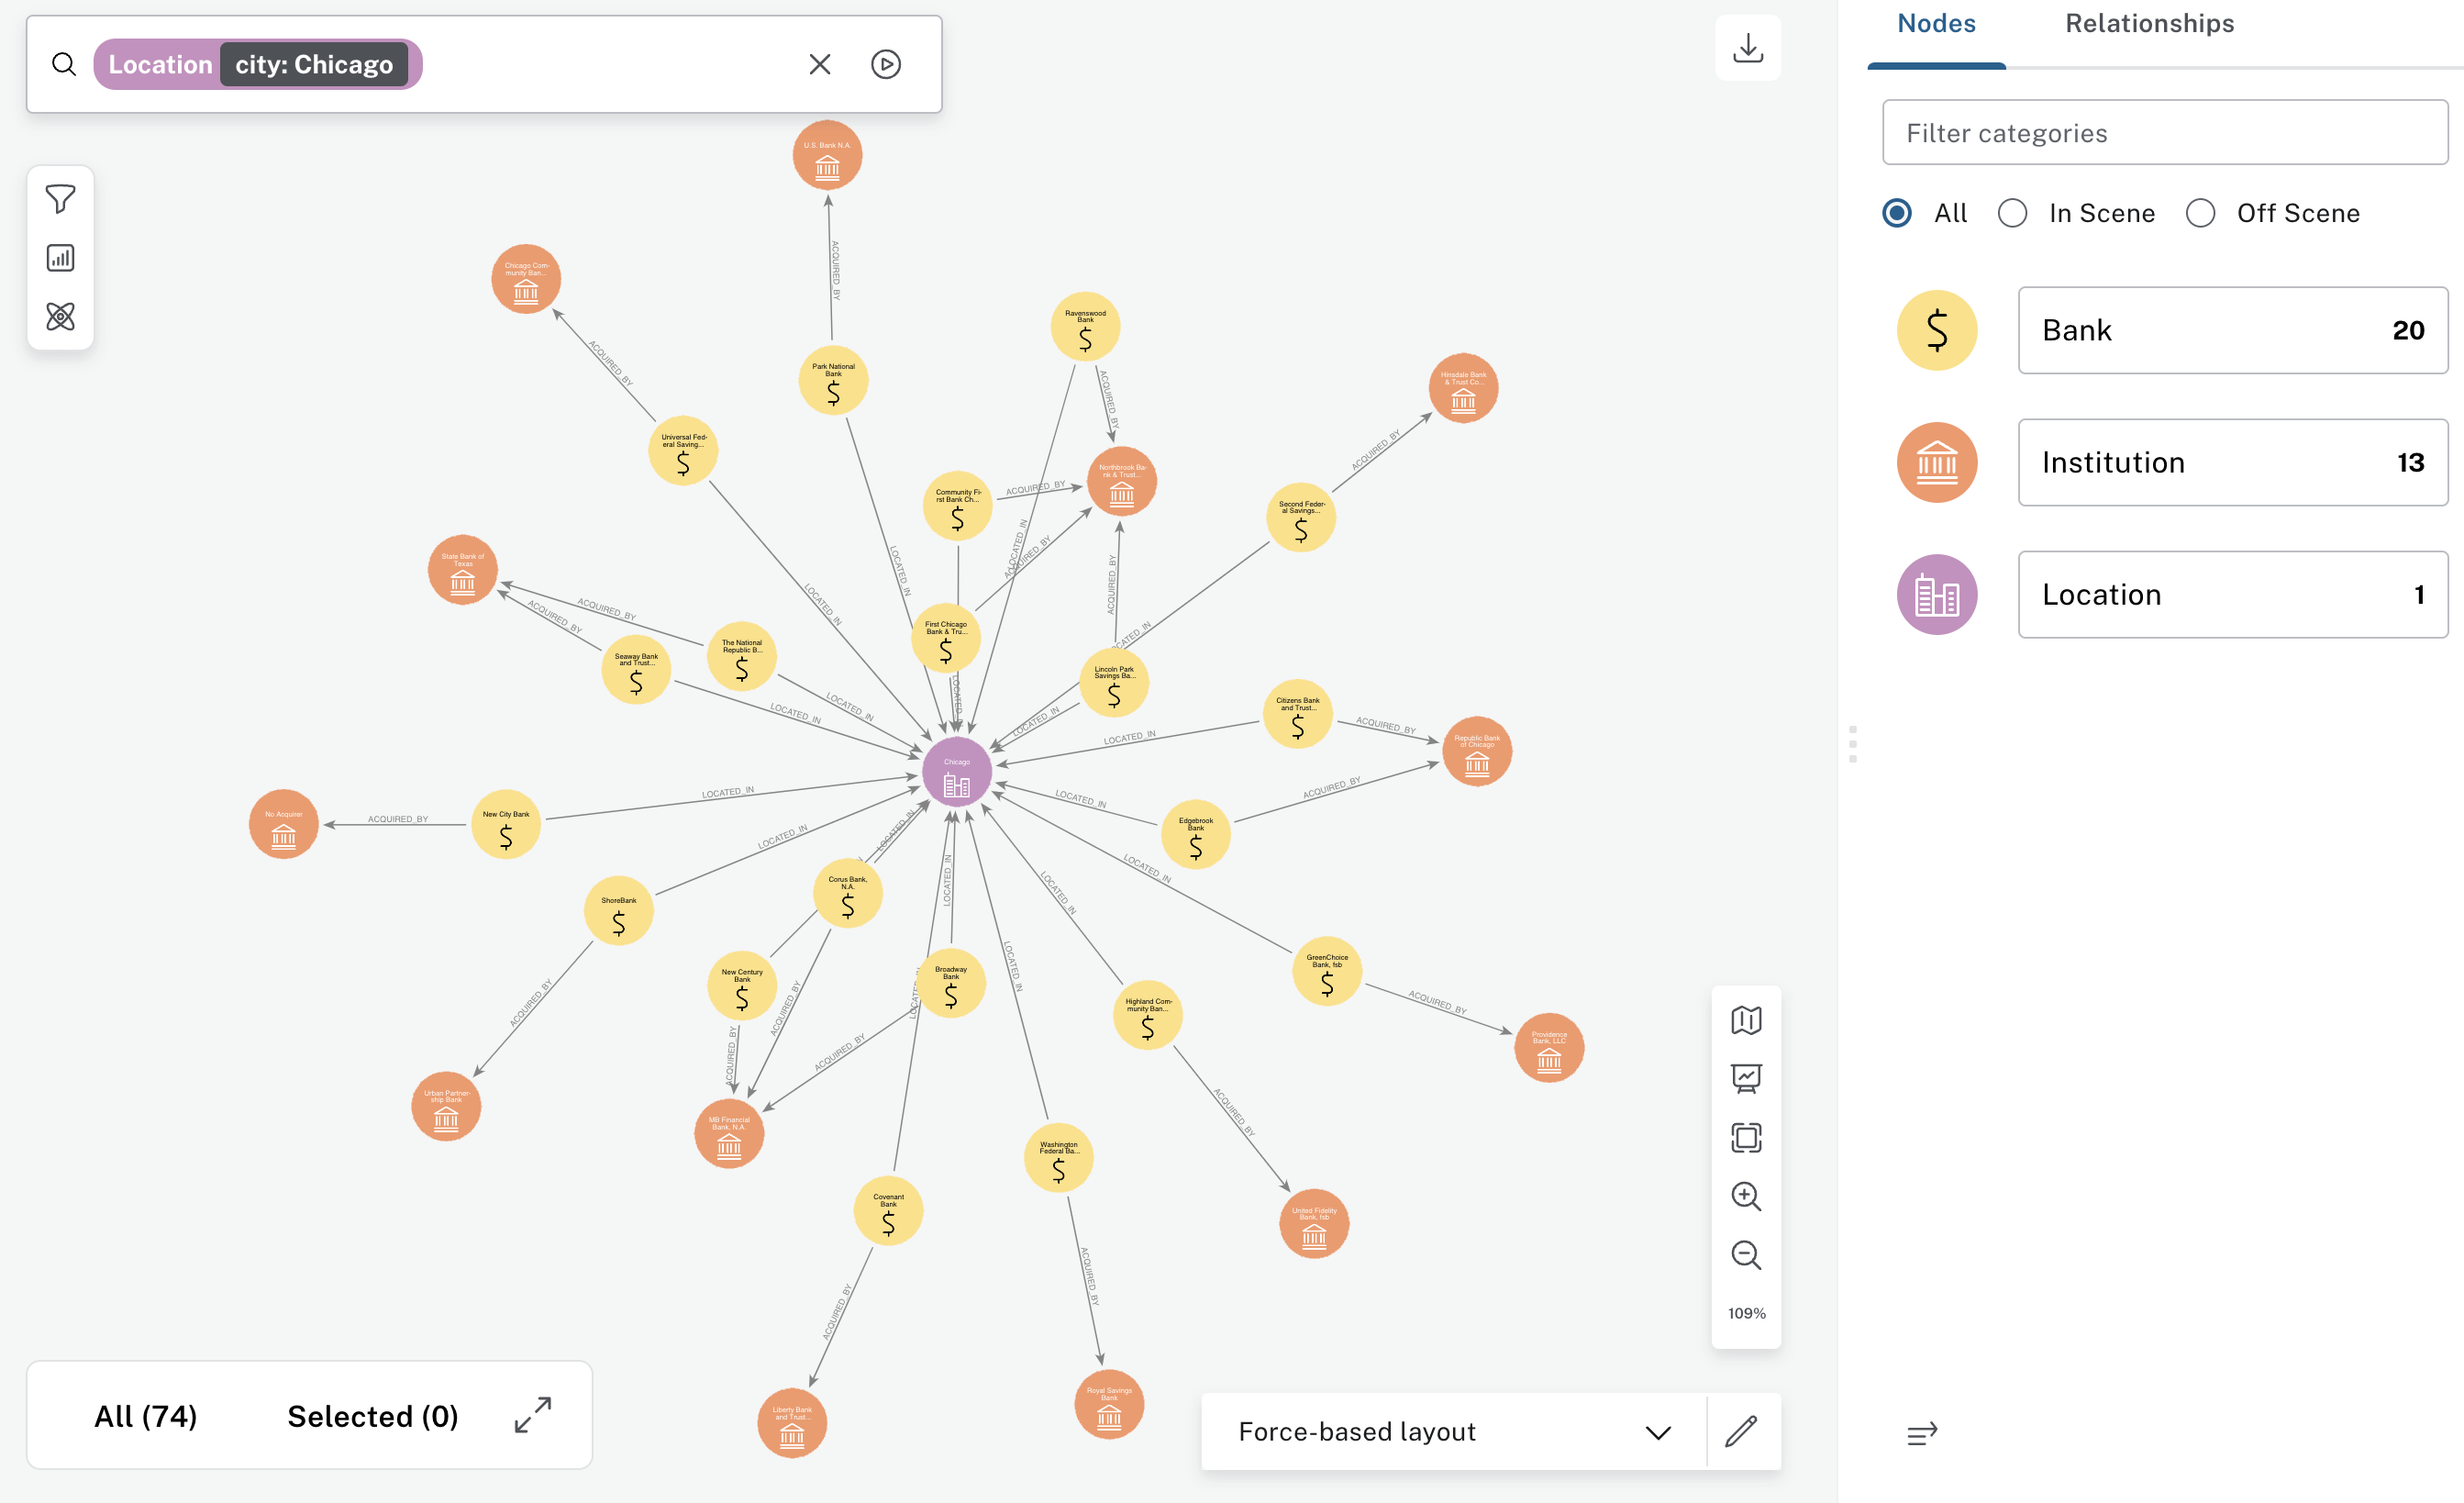

In [33]:
# display image of graph
Image(filename='chicago-failed-banks.png')

## Conclusion
In this notebook we demonstrated how to use Neo4j Runway to explore a new tabular dataset, generate a graph data model, and load the data into Neo4j. This process is designed to be iterative and to get you from tabular data to a working graph database as quickly as possible.

Neo4j Runway is an open source project under active development and we welcome contributions and feedback.